In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gap_statistic import OptimalK
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

## Construct the OptimalK class using the joblib backend
### Supported backends are:
- joblib
- multiprocessing (python builtin)
- None (use single core)

In [2]:
optimalK = OptimalK(parallel_backend='rust')
optimalK

OptimalK(n_jobs=8, parallel_backend="rust")

## Create test data, with 3 cluster centers and call optimalK with a list of  clusters to fit to.

In [3]:
X, y = make_blobs(n_samples=int(1e5), n_features=2, centers=3, random_state=25)
print('Data shape: ', X.shape)

n_clusters = optimalK(X, cluster_array=np.arange(1, 15))
print('Optimal clusters: ', n_clusters)

Data shape:  (100000, 2)
Optimal clusters:  3


## A DataFrame of gap values with each passed cluster count is now available

In [4]:
optimalK.gap_df.head()

,n_clusters,gap_value,ref_dispersion_std
0,1.0,-6.058082,90.025799
1,2.0,-3.030001,753.158691
2,3.0,-2.858020,826.399548
3,4.0,-2.972589,5428.560563
4,5.0,-3.280151,2940.826412


## Plot the n_clusters against their gap values.

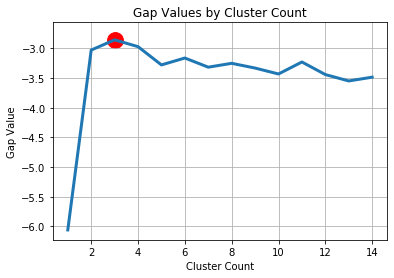

In [5]:
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=3)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

## `optimalK()` returns n_clusters, we can use that to fit the final KMeans model...

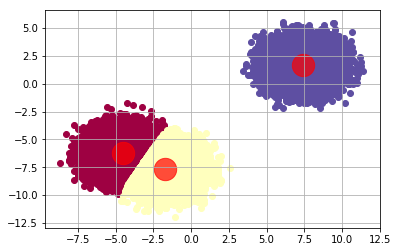

In [6]:
# Now that we have the optimal clusters, n, we build our own KMeans model...
km = KMeans(n_clusters)
km.fit(X)

df = pd.DataFrame(X, columns=['x','y'])
df['label'] = km.labels_

colors = plt.cm.Spectral(np.linspace(0, 1, len(df.label.unique())))

for color, label in zip(colors, df.label.unique()):
    
    tempdf = df[df.label == label]
    plt.scatter(tempdf.x, tempdf.y, c=color)
    
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:, 1], c='r', s=500, alpha=0.7, )
plt.grid(True)
plt.show()

### Notes:

Please be aware that, as the image above hints to, number of clusters can be subjective. This is merely meant to provide a suggestion to the number of clusters in your data; the true amount can vary depending upon your specific objective. The clusters here can be interpreted as three, but also clearly just two. Also due to random initialization, the suggested n_clusters could also vary.

---

### Use your own clustering algorithm! (Added in v1.6.0)

As the default implementation is KMeans, but Gap Statistic allows using any clusting algorithm, you can define your own in the following example:


---

#### First, define a function which takes `X` and `k`, it _must_ return a tuple of the centroid locations, and the labels assigned to `X`

In [7]:
# We'll wrap the `MeanShift` algorithm from sklearn

from sklearn.cluster import MeanShift

def special_clustering_func(X, k):
    """ 
    Special clustering function which uses the MeanShift
    model from sklearn.
    
    These user defined functions *must* take the X and a k 
    and can take an arbitrary number of other kwargs, which can
    be pass with `clusterer_kwargs` when initializing OptimalK
    """
    
    # Here you can do whatever clustering algorithm you heart desires,
    # but we'll do a simple wrap of the MeanShift model in sklearn.
    
    m = MeanShift()
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)

# Make some data
X, y = make_blobs(n_samples=50, n_features=2, centers=3, random_state=25)

# Define the OptimalK instance, but pass in our own clustering function
optimalk = OptimalK(clusterer=special_clustering_func)

# Use the callable instance as normal.
n_clusters = optimalk(X, n_refs=3, cluster_array=range(1, 4))